# Logistic Regression AD Image Baseline

## Imports

In [1]:
import os
import pandas as pd

## Import data and create .csv

In [2]:
# Directory to MRI Images
base_dir = '/Users/benrandoing/Downloads/archive/AugmentedAlzheimerDataset'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

if not os.path.exists('dataset.csv'):
    data = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            data.append([image_path, label])

    df = pd.DataFrame(data, columns=['path', 'label'])
    df.to_csv('dataset.csv', index=False)

## Data Loading and Pre-Processing

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize image to 128x128
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load the entire dataset
dataset = CustomDataset(csv_file='dataset.csv', transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [4]:
print(f'Training Samples: {len(train_dataset)}')
print(f'Validation Samples: {len(val_dataset)}')
print(f'Test Samples: {len(test_dataset)}')

Training Samples: 23788
Validation Samples: 5097
Test Samples: 5099


In [5]:
print(train_dataset)

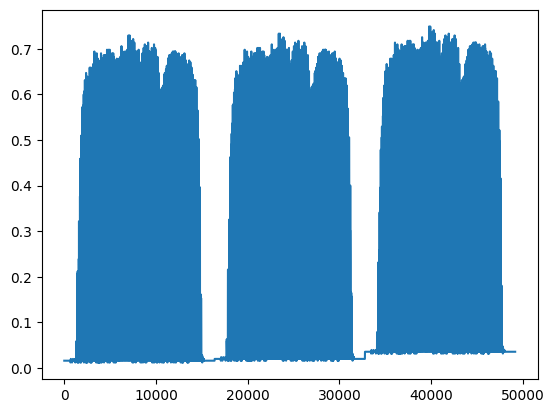

In [6]:
import matplotlib.pyplot as plt
plt.plot(train_dataset[0][0])
plt.show()

## Pytorch Logistic Regression Model

In [7]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

input_dim = 128*128*3  # Assuming the images are RGB
output_dim = 4  # Four classes

model = LogisticRegression(input_dim, output_dim)

## Training Loop

## Evaluation

In [11]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define hyperparameters
learning_rate = 0.001
num_epochs = 10
batch_size = 64

# Define DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    print("num_epochs",num_epochs)
    print("\n")
    model.train()
    total_loss = 0.0

    i = 0
    for inputs, labels in train_loader:
        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        i = i + 1
        if i % 1000 == 0:
            print("total loss = ", total_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {total_loss / len(train_loader)}")



num_epochs 10


Epoch [1/10] - Loss: 1.0723425387054362
num_epochs 10


Epoch [2/10] - Loss: 1.0458429563109592
num_epochs 10


Epoch [3/10] - Loss: 1.0180882475068491
num_epochs 10


Epoch [4/10] - Loss: 0.9984283814186691
num_epochs 10


Epoch [5/10] - Loss: 0.9882370164637925
num_epochs 10


Epoch [6/10] - Loss: 0.9743228698930433
num_epochs 10


Epoch [7/10] - Loss: 0.9416855740290816
num_epochs 10


Epoch [8/10] - Loss: 0.9511594051314939
num_epochs 10


Epoch [9/10] - Loss: 0.9456455944686808
num_epochs 10


Epoch [10/10] - Loss: 0.926179418640752


In [14]:
# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = 100 * correct / total
print(f"Validation Accuracy: {validation_accuracy}%")

Validation Accuracy: 54.99313321561703%


In [13]:
# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 54.7558344773485%
